In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random

/Users/lorenh/Documents/DSaPP/.aequitas/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [56]:
# Squarified Treemap Layout
# Implements algorithm from Bruls, Huizing, van Wijk, "Squarified Treemaps"
#   (but not using their pseudocode)

def normalize_sizes(sizes, dx, dy):
    total_size = sum(sizes)
    total_area = dx * dy
    sizes = map(float, sizes)
    sizes = map(lambda size: size * total_area / total_size, sizes)
    return list(sizes)


def layoutrow(sizes, x, y, dx, dy):
    # generate rects for each size in sizes
    # dx >= dy
    # they will fill up height dy, and width will be determined by their area
    # sizes should be pre-normalized wrt dx * dy (i.e., they should be same units)
    print("layoutrow")
    covered_area = sum(sizes)
    width = covered_area / dy
    rects = []
    heights = 0
    for size in sizes:
        rects.append({'x': x, 'y': dy - (size / width), 'dx': width, 'dy': size / width})
        dy -= size / width
        print(f"dy{dy}, dx{dx}, height:{size / width} and start-point:{dy - (size / width)}")
    return rects

def layoutcol(sizes, x, y, dx, dy):
    # generate rects for each size in sizes
    # dx < dy
    # they will fill up width dx, and height will be determined by their area
    # sizes should be pre-normalized wrt dx * dy (i.e., they should be same units)
    print("layoutcol")
    covered_area = sum(sizes)
    height = covered_area / dx
    rects = []
    for size in sizes:
        rects.append({'x': x, 'y': dy - height, 'dx': size / height, 'dy': height})
        x += size / height
    return rects

def layout(sizes, x, y, dx, dy):
    return layoutrow(sizes, x, y, dx, dy) if dx >= dy else layoutcol(sizes, x, y, dx, dy)

def leftoverrow(sizes, x, y, dx, dy):
    # compute remaining area when dx >= dy
    covered_area = sum(sizes)
    width = covered_area / dy
    leftover_x = x + width
    leftover_y = dy
    leftover_dx = dx - width
    leftover_dy = dy
    print(f"leftover-col: x: {leftover_x}, y: {leftover_y}, dx: {leftover_dx}, dy: {leftover_dy}")
    return (leftover_x, leftover_y, leftover_dx, leftover_dy)

def leftovercol(sizes, x, y, dx, dy):
    # compute remaining area when dx < dy
    covered_area = sum(sizes)
    height = covered_area / dx
    leftover_x = x
    leftover_y = dy
    leftover_dx = dx
    leftover_dy = dy - height
    print(f"leftover-col: x: {leftover_x}, y: {leftover_y}, dx: {leftover_dx}, dy: {leftover_dy}")
    return (leftover_x, leftover_y, leftover_dx, leftover_dy)


def leftover(sizes, x, y, dx, dy):
    print("checking leftover area")
    return leftoverrow(sizes, x, y, dx, dy) if dx >= dy else leftovercol(sizes, x, y, dx, dy)

def worst_ratio(sizes, x, y, dx, dy):
    return max([max(rect['dx'] / rect['dy'], rect['dy'] / rect['dx']) for rect in layout(sizes, x, y, dx, dy)])

In [57]:
def squarify(sizes, x, y, dx, dy):
    # sizes should be pre-normalized wrt dx * dy (i.e., they should be same units)
    # or dx * dy == sum(sizes)
    # sizes should be sorted biggest to smallest
    sizes = list(map(float, sizes))
    
    if len(sizes) == 0:
        return []
    
    if len(sizes) == 1:
        return layout(sizes, x, y, dx, dy)
    
    # figure out where 'split' should be
    i = 1
    while i < len(sizes) and worst_ratio(sizes[:i], x, y, dx, dy) >= worst_ratio(sizes[:(i+1)], x, y, dx, dy):
        i += 1
        print(f"while loop {i}")
    "while loop broken"
    current = sizes[:i]
    
    remaining = sizes[i:]
    
    (leftover_x, leftover_y, leftover_dx, leftover_dy) = leftover(current, x, y, dx, dy)
    print()
    print(f"about to layout {current} x:{x}, y:{y}, dx:{dx}, dy:{dy} -- {layout(current, x, y, dx, dy)}")
    print(f"squarifying the rest: {remaining}--leftover_x:{leftover_x}, leftover_y:{leftover_x}, leftover_dx:{leftover_dx}, leftover_dy:{leftover_dy}")
    return layout(current, x, y, dx, dy) + \
            squarify(remaining, leftover_x, leftover_y, leftover_dx, leftover_dy)

def pad_rectangle(rect):
    if rect['dx'] > 2:
        rect['x'] += 1
        rect['dx'] -= 2
    if rect['dy'] > 2:
        rect['y'] += 1
        rect['dy'] -= 2

def padded_squarify(sizes, x, y, dx, dy):
    rects = squarify(sizes, x, y, dx, dy)
    for rect in rects:
        pad_rectangle(rect)
    return rects

In [58]:
def squarify_plot_rects(rects, norm_x=100, norm_y=100, color=None,
                        ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    if color is None:
        
        cmap = cm.get_cmap()
        color = [cmap(random.random()) for i in range(len(rects))]

    x = [rect['x'] for rect in rects]
    y = [rect['y'] for rect in rects]
    dx = [rect['dx'] for rect in rects]
    dy = [rect['dy'] for rect in rects]

    ax.bar(x, dy, width=dx, bottom=y, color=color,
           align='edge', **kwargs)


    ax.set_xlim(0, norm_x)
    ax.set_ylim(0, norm_y)
    return ax

normed:[3846.153846153846, 1923.076923076923, 1442.3076923076924, 1153.8461538461538, 576.9230769230769, 480.7692307692308, 384.61538461538464, 192.30769230769232]
layoutrow
dy0.0, dx100.0, height:100.0 and start-point:-100.0
layoutrow
dy33.33333333333333, dx100.0, height:66.66666666666667 and start-point:-33.33333333333334
dy-7.105427357601002e-15, dx100.0, height:33.333333333333336 and start-point:-33.33333333333334
while loop 2
layoutrow
dy33.33333333333333, dx100.0, height:66.66666666666667 and start-point:-33.33333333333334
dy-7.105427357601002e-15, dx100.0, height:33.333333333333336 and start-point:-33.33333333333334
layoutrow
dy46.666666666666664, dx100.0, height:53.333333333333336 and start-point:-6.666666666666671
dy19.999999999999996, dx100.0, height:26.666666666666668 and start-point:-6.666666666666671
dy-3.552713678800501e-15, dx100.0, height:20.0 and start-point:-20.000000000000004
checking leftover area
leftover-col: x: 57.69230769230769, y: 100.0, dx: 42.30769230769231, 

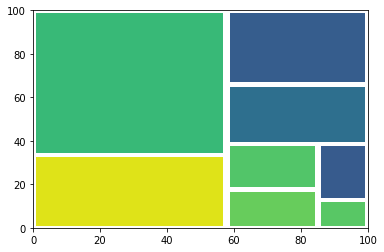

In [59]:
x = 0.
y = 0.
width = 100.
height = 100.
scaled_values = [40, 12, 2, 6, 15, 4, 20, 5]
normed = normalize_sizes(sorted(scaled_values, reverse=True), width, height)
print(f"normed:{normed}")
padded_rects = padded_squarify(normed, x, y, width, height)
squarify_plot_rects(padded_rects, norm_x=100, norm_y=100,ax=None)